# Signed Graph Network Analysis 2

### Setup

In [96]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
from matplotlib_venn import venn2

### Data Import, Matrix, Print to Excel, Dataset graph

In [11]:
graph_df = pd.read_csv("data/soc-sign-bitcoinalpha.csv", header=None)
graph_df.columns = ["source", "target", "weight", "time"]
G = nx.from_pandas_edgelist(graph_df, source="source", target="target", edge_attr="weight", create_using=nx.DiGraph)

graph_df

,source,target,weight,time
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400
...,...,...,...,...
24181,7604,7601,10,1364270400
24182,7601,7604,10,1364270400
24183,7604,7602,10,1364270400
24184,7602,7604,10,1364270400


In [9]:
# Part A to compile Excel file
adjacency_matrix = nx.adjacency_matrix(G).todense()
print("Shape of the adjacency matrix: ", adjacency_matrix.shape)

#save to excel file
adjacency_df = pd.DataFrame(adjacency_matrix)

adjacency_df.to_excel("data/adjacency_matrix.xlsx", index=False)

Shape of the adjacency matrix:  (3783, 3783)


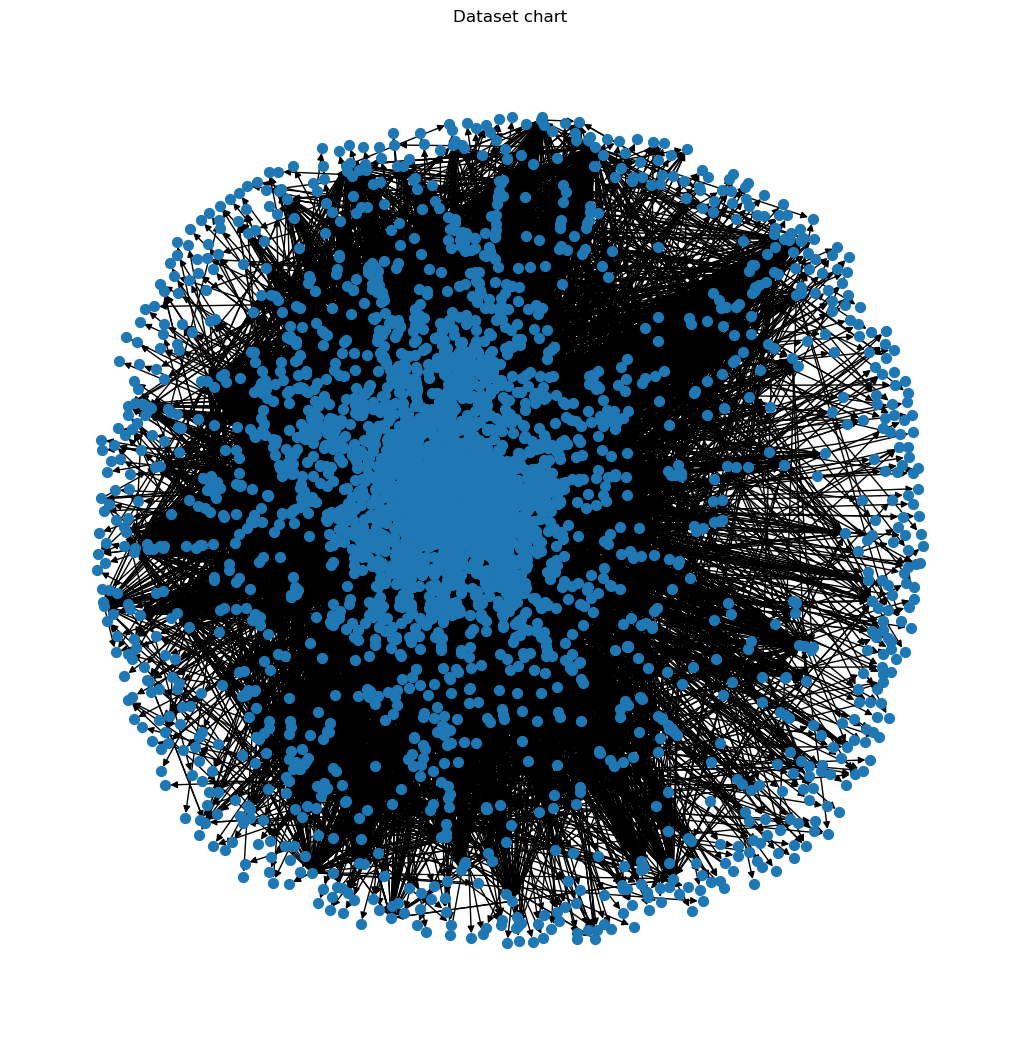

In [95]:
plt.figure(figsize=(10, 10))
nx.draw(G, node_size = 50)
filename = "plots/Dataset_chart.pdf"
plt.savefig(filename)
plt.title(f"Dataset chart")
plt.show()

### C) K-plex Communities

In [108]:
#Part C, k-plex analysis function

#3. Identify the communities of the network using k-plex algorithm as implemented in
#Networkx. Use appropriate visualization tools to display a dense representation of these
#communities.

#How to use k-plex in NetworkX?
#k-plex is not directly implemented in NetowrkX
#You can look at alternative existing implementations elsewhere.. For instance in https://github.com/bachsh/kplex/blob/master/tests.py  (need to check if it is updated)- or another source
#You can also make some program on your own.. For instance you can start by identifying the largest component in the graph, 
#say V, and the smallest degree d of all nodes of V, then the k-value (in k-plex) whose outcome will be the subgraph V is |V|-d.  
#You can proceed by exploring other components in the graph and identify the corresponding value of k accordingly as previously.. 
#Check for specific value of k, the result should be associated to the largest set (subgraph).. 

def analyze_k_plexes(G, name):

    # Largest strongly connected component
    def largest_strongly_connected_component(graph):
        components = list(nx.strongly_connected_components(graph))
        largest_component = max(components, key=len)
        return graph.subgraph(largest_component)

    # Calculate k-value based on the minimum degree
    def calculate_k(subgraph):
        min_degree = min(dict(subgraph.degree()).values())
        k = max(1, min(len(subgraph) - min_degree, len(subgraph) // 2))
        return k

    # Find k-plexes in the directed graph
    def find_k_plex(graph, k):
        components = list(nx.strongly_connected_components(graph))
        k_plexes = []

        for component in components:
            subgraph = graph.subgraph(component)
            if all(degree >= (len(subgraph) - k) for _, degree in subgraph.degree()):
                k_plexes.append(subgraph)

        return k_plexes

    # Plot k-plexes
    def plot_k_plexes(graph, k_plexes):
        pos = nx.spring_layout(graph)  # Layout
        plt.figure(figsize=(10, 10))

        colors = plt.cm.rainbow(np.linspace(0, 1, len(k_plexes)))
        for color, k_plex in zip(colors, k_plexes):
            nx.draw(k_plex, pos, node_color=color, edge_color='black', alpha=0.8, node_size=200)

        plt.title(f"K-Plex nodes")
        filename = "plots/" + name + "_k_plex_communities.pdf"
        plt.savefig(filename)
        plt.show()

    # Plot k-plexes with node size variation
    def plot_k_plexes_nodes(graph, k_plexes):
        pos = nx.spring_layout(graph)  # Layout
        plt.figure(figsize=(10, 10))

        # Vary node size based on degree
        degrees = dict(graph.degree())
        colors = plt.cm.rainbow(np.linspace(0, 1, len(k_plexes)))
        for color, k_plex in zip(colors, k_plexes):
            node_sizes = [degrees[node] * 100 for node in k_plex.nodes()]  # Scale factor for node size
            nx.draw(k_plex, pos, node_color=color, edge_color='black', alpha=0.8, node_size=node_sizes)

        filename = "plots/" + name + "_k_plex_communities_nodes.pdf"
        plt.title(f"K-Plex node size variation")
        plt.savefig(filename)
        plt.show()

    # Function to plot the degree histogram for k-plex nodes
    def plot_degree_histogram(graph, k_plexes):
        all_nodes = set()
        for k_plex in k_plexes:
            all_nodes.update(k_plex.nodes())

        degrees = [d for _, d in graph.degree(all_nodes)]

        plt.figure(figsize=(10, 6))
        plt.hist(degrees, bins=100, color='blue', label="K-Plex Degrees")
        plt.xlabel("Degree")
        plt.ylabel("Count")
        plt.legend()
        filename = "plots/" + name + "_k_plex_histogram.pdf"
        plt.savefig(filename)
        plt.show()

    # Conducting analysis
    largest_component = largest_strongly_connected_component(G)
    k = calculate_k(largest_component)
    k_plexes = find_k_plex(G, k)
    print(len(k_plexes))
    #plot_k_plexes(G, k_plexes)  # Base plot
    #plot_k_plexes_nodes(G, k_plexes) # Node size plot
    #plot_degree_histogram(G, k_plexes)  # Histogram
    
    return (k, k_plexes)

In [109]:
# Part C function call
name = "C"
k_plex_info = analyze_k_plexes(G, name)

539


### D) Positive and Negative Matrices

In [14]:
# Part D, making positive and negative adjacency matrices
#Now we want to compare the result with that obtained when the sign information is ignored from the network. For this purpose, consider two graphs 
#from the original. The first one assumes only the edge of positive weights (the edge of negative weights are not represented in the network). 
#The second one assumes only the edges of negative weights (the edges of positive weights are not represented), and the negative weights are turned into positive.
#Write a script to save the adjacency matrices of the two newly created graphs into an excel file.

# Create a new graph with only positive weighted edges
G_positive = nx.DiGraph()
for u, v, w in G.edges(data=True):
    if w["weight"] > 0:
        G_positive.add_edge(u, v, weight=w["weight"])

# Create a new graph with only negative weighted edges, turning them positive
G_negative = nx.DiGraph()
for u, v, w in G.edges(data=True):
    if w["weight"] < 0:
        G_negative.add_edge(u, v, weight=abs(w["weight"]))


# Save adjacency matrices
adjacency_positive = nx.to_pandas_adjacency(G_positive)
adjacency_negative = nx.to_pandas_adjacency(G_negative)

# Saving matrices as excel files
print("Positive matrix")
print(adjacency_positive)

adjacency_positive.to_excel("data/positive_adjacency_matrix.xlsx", index=False, header=False)

print("Negative matrix")
print(adjacency_negative)

adjacency_negative.to_excel("data/negative_adjacency_matrix.xlsx", index=False, header=False)

Positive matrix
      7188  1     160   1028  309   11    594   1316  1392  1583  ...  2666  \
7188   0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0  10.0   7.0   5.0   5.0   5.0   5.0   4.0   4.0  ...   0.0   
160    0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1028   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
309    0.0   5.0   0.0   0.0   0.0   3.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
7452   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7451   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3296   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6336   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3228   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      3271  1870  2578  6157  7452 

### E) Rerunning part B

In [19]:
# Part B import for Part E use
def calculate_degrees(degree_dict):
    degree_sequence = sorted([d for n, d in degree_dict], reverse=True)
    degree_count = {}
    for degree in degree_sequence:
        if degree in degree_count:
            degree_count[degree] += 1
        else:
            degree_count[degree] = 1
    return zip(*degree_count.items())


def plot_degree(degree, count, title, save_path):
    plt.bar(degree, count, color='b', label = "NumberOfNodes")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.xlim(0, 100)
    plt.ylim(0, max(count))
    plt.legend()
    plt.savefig(f"plots/{save_path}.pdf")
    #keep title out of saved version
    plt.title(title)
    plt.show()

def linlaw(x, a, b) :
    return np.log(a) + x * b

def fit_and_plot_powerlaw(degree, count, title, save_path):
    degree, count = np.log(degree)[:-1], np.log(count)[:-1]
    popt_log, pcov_log = curve_fit(linlaw, degree, count)

    hires_x = np.linspace(0, max(degree), 100)
    # Calculate standard errors of the parameters
    sigma_ab = np.sqrt(np.diagonal(pcov_log))

    # Calculate critical value for an 80% confidence interval
    z = norm.ppf(0.9)  # for an 80% confidence interval

    # Calculate confidence bounds
    bound_upper = linlaw(hires_x, *(popt_log + z * sigma_ab))
    bound_lower = linlaw(hires_x, *(popt_log - z * sigma_ab))

    print(f"Optimal parameters: a={popt_log[0]}, b={popt_log[1]}")
    plt.scatter(degree, count, color='b')
    plt.plot(degree, linlaw(degree, *popt_log), 'r--', label = "Fitted Curve")
    plt.fill_between(hires_x, bound_lower, bound_upper, color='black', alpha=0.15, label='80% Confidence Interval')  # plotting the confidence intervals
    plt.xlabel("log(Degree)")
    plt.ylabel("log(Count)")
    plt.legend(loc='best')
    plt.savefig(f"plots/{save_path}.pdf")
    plt.title(title)
    plt.show()


In [143]:
### Testing 


# Linear fit for the power law
def linlaw(x, a, b):
    return np.log(a) + x * b

# Function to fit power law and plot for two datasets
def fit_and_plot_powerlaw_multi(data_dict, title, save_path):
    plt.figure(figsize=(10, 6))

    # Loop through each dataset in the dictionary
    for key, data in data_dict.items():
        # Log-transform the degrees and counts
        degree, count = np.log(data['degree']), np.log(data['count'])
        
        # Fit power law and obtain confidence intervals
        popt_log, pcov_log = curve_fit(linlaw, degree, count)
        sigma_ab = np.sqrt(np.diagonal(pcov_log))
        z = norm.ppf(0.9)  # 80% confidence interval
        hires_x = np.linspace(0, max(degree), 100)

        # Calculate confidence bounds
        bound_upper = linlaw(hires_x, *(popt_log + z * sigma_ab))
        bound_lower = linlaw(hires_x, *(popt_log - z * sigma_ab))
        
        # Plot the scatter, fitted curve, and confidence interval
        plt.scatter(degree, count, label=f"{key} data")
        plt.plot(degree, linlaw(degree, *popt_log), '--', label=f"Fitted Curve ({key})")
        plt.fill_between(hires_x, bound_lower, bound_upper, alpha=0.15, label=f'80% Confidence Interval ({key})')

    # Adding labels, legends, and title
    plt.xlabel("log(Degree)")
    plt.ylabel("log(Count)")
    plt.legend(loc='best')
    plt.title(title)
    plt.savefig(f"plots/{save_path}.pdf")
    plt.show()



In [144]:
### Testing 


positive_in_degree, positive_in_count = calculate_degrees(G_positive.in_degree())
positive_out_degree, positive_out_count = calculate_degrees(G_positive.out_degree())
negative_in_degree, negative_in_count = calculate_degrees(G_negative.in_degree())
negative_out_degree, negative_out_count = calculate_degrees(G_negative.out_degree())
# Define the data for in-degrees
new_in_degree_data = {
    "Positive in-degree": {"degree": positive_in_degree, "count": positive_in_count},
    "Negative in-degree": {"degree": negative_in_degree, "count": negative_in_count},
}

# Call the new function with in-degree data
fit_and_plot_powerlaw_multi(new_in_degree_data, "In-Degree Distribution Power-Law Fit", "E_In_Degree_Distribution_Powerlaw_Fit")

# Define the data for out-degrees
new_out_degree_data = {
    "Positive out-degree": {"degree": positive_out_degree, "count": positive_out_count},
    "Negative out-degree": {"degree": negative_out_degree, "count": negative_out_count},
}

# Call the new function with out-degree data
fit_and_plot_powerlaw_multi(new_out_degree_data, "Out-Degree Distribution Power-Law Fit", "E_Out_Degree_Distribution_Powerlaw_Fit")



C:\Users\minda\AppData\Local\Temp\ipykernel_31544\146842737.py:12: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(data['degree']), np.log(data['count'])


ValueError: array must not contain infs or NaNs

<Figure size 1000x600 with 0 Axes>

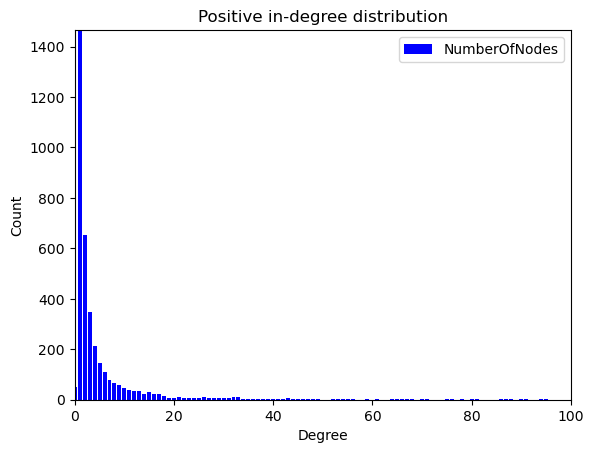

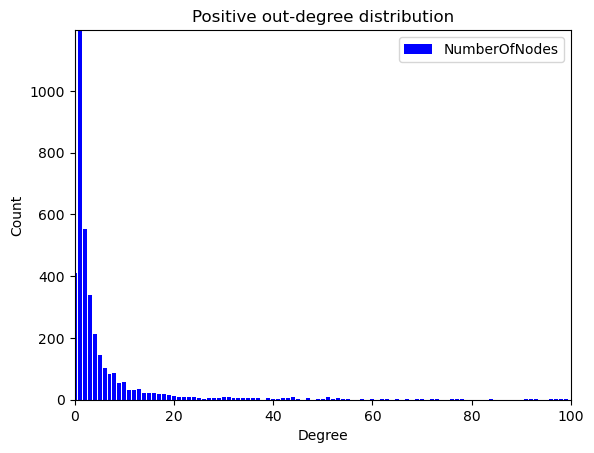

C:\Users\minda\AppData\Local\Temp\ipykernel_31544\754910014.py:29: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=960.2197576396969, b=-1.4535518253135855


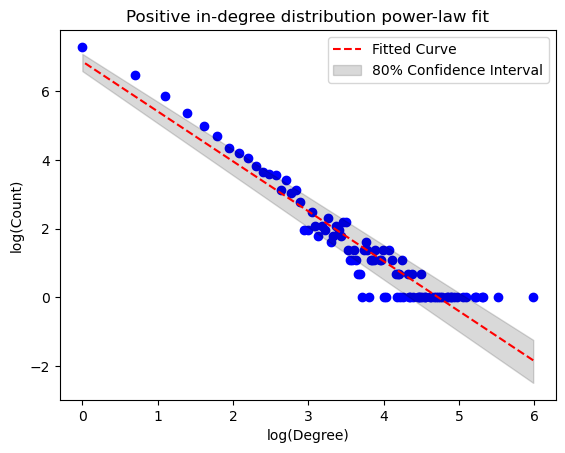

C:\Users\minda\AppData\Local\Temp\ipykernel_31544\754910014.py:29: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=909.2416580777029, b=-1.4274171221293463


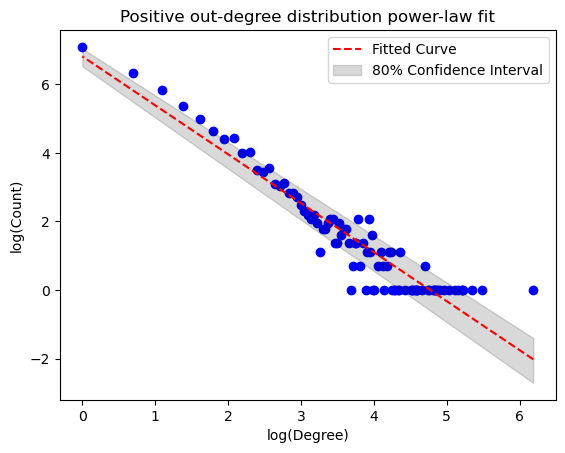

Percentage of nodes with in-degree under 10: 0.8645126255769753
Percentage of nodes with out-degree under 10: 0.8642411077925604


In [28]:
#Part E, positive weights calculations

positive_in_degree, positive_in_count = calculate_degrees(G_positive.in_degree())
plot_degree(positive_in_degree, positive_in_count, "Positive in-degree distribution", "E_Positive_in_degree_distribution")
positive_out_degree, positive_out_count = calculate_degrees(G_positive.out_degree())
plot_degree(positive_out_degree, positive_out_count, "Positive out-degree distribution", "E_Positive_out_degree_distribution")

fit_and_plot_powerlaw(positive_in_degree, positive_in_count, "Positive in-degree distribution power-law fit", "E_Positive_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw(positive_out_degree, positive_out_count, "Positive out-degree distribution power-law fit", "E_Positive_out_degree_distribution_powerlaw_fit")

# percentage of nodes with in / out degress under 20
positive_in_degree_under_10= sum(positive_in_count[-10:]) / sum(positive_in_count)
positive_out_degree_under_10 = sum(positive_out_count[-10:]) / sum(positive_out_count)

print(f"Percentage of nodes with in-degree under 10: {positive_in_degree_under_10}")
print(f"Percentage of nodes with out-degree under 10: {positive_out_degree_under_10}")

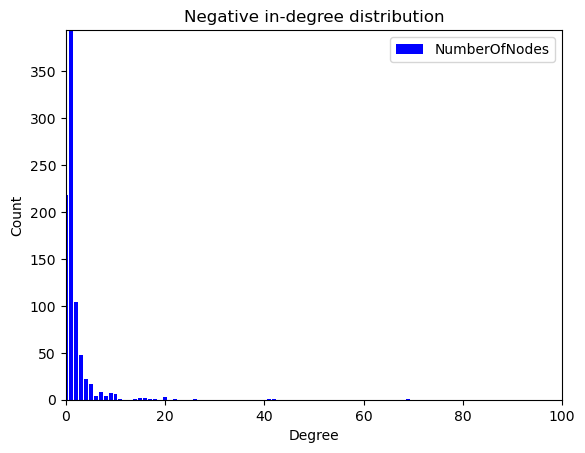

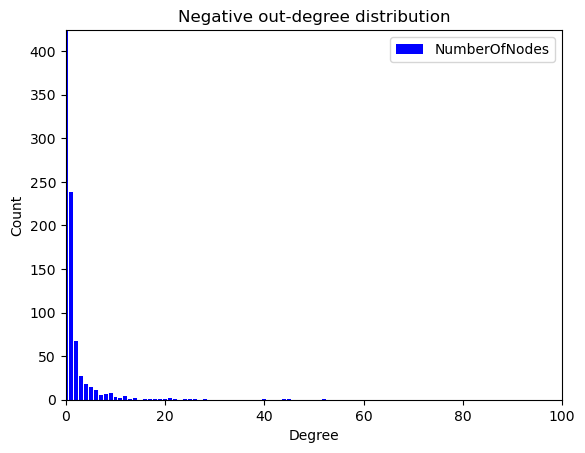

C:\Users\minda\AppData\Local\Temp\ipykernel_31544\754910014.py:29: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=163.85568524025382, b=-1.5405373337394612


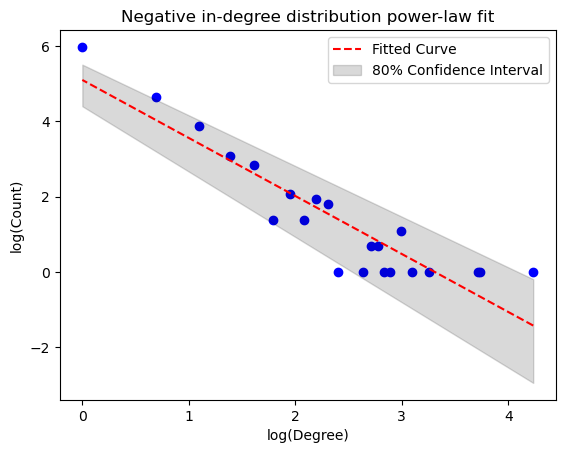

C:\Users\minda\AppData\Local\Temp\ipykernel_31544\754910014.py:29: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=83.50380475258244, b=-1.2894855333108255


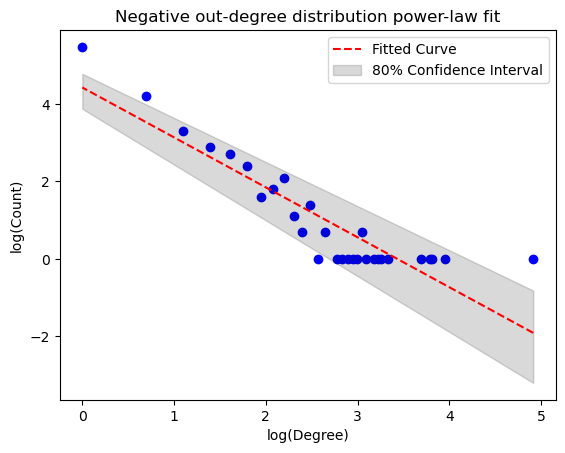

In [29]:
#Part E, negative weights calculations

negative_in_degree, negative_in_count = calculate_degrees(G_negative.in_degree())
plot_degree(negative_in_degree, negative_in_count, "Negative in-degree distribution", "E_Negative_in_degree_distribution")
negative_out_degree, negative_out_count = calculate_degrees(G_negative.out_degree())
plot_degree(negative_out_degree, negative_out_count, "Negative out-degree distribution", "E_Negative_out_degree_distribution")

fit_and_plot_powerlaw(negative_in_degree, negative_in_count, "Negative in-degree distribution power-law fit", "E_Negative_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw(negative_out_degree, negative_out_count, "Negative out-degree distribution power-law fit", "E_Negative_out_degree_distribution_powerlaw_fit")



In [30]:
# percentage of nodes with in / out degress under 20
negative_in_degree_under_10= sum(negative_in_count[-10:]) / sum(negative_in_count)
negative_out_degree_under_10 = sum(negative_out_count[-10:]) / sum(negative_out_count)

print(f"Percentage of nodes with in-degree under 10: {negative_in_degree_under_10}")
print(f"Percentage of nodes with out-degree under 10: {negative_out_degree_under_10}")

Percentage of nodes with in-degree under 10: 0.9740566037735849
Percentage of nodes with out-degree under 10: 0.9658018867924528


In [133]:
# POSITIVE
#Additionally, calculate the average clustering coefficient and diameter.
positive_average_clustering_coefficient = nx.average_clustering(G_positive)
print("Average positive clustering coefficient: ", positive_average_clustering_coefficient)

#identify biggest strongly connected component first
positive_strongly_connected_components = nx.strongly_connected_components(G_positive)
positive_biggest_strongly_connected_component = max(positive_strongly_connected_components, key=len)
positive_G_strongly_connected = G_positive.subgraph(positive_biggest_strongly_connected_component)
positive_diameter = nx.diameter(positive_G_strongly_connected)
print("Positive Diameter: ", positive_diameter)

# NEGATIVE
#Additionally, calculate the average clustering coefficient and diameter.
negative_average_clustering_coefficient = nx.average_clustering(G_negative)
print("Average negative clustering coefficient: ", negative_average_clustering_coefficient)

#identify biggest strongly connected component first
negative_strongly_connected_components = nx.strongly_connected_components(G_negative)
negative_biggest_strongly_connected_component = max(negative_strongly_connected_components, key=len)
negative_G_strongly_connected = G_negative.subgraph(negative_biggest_strongly_connected_component)
negative_diameter = nx.diameter(negative_G_strongly_connected)
print("Negative Diameter: ", negative_diameter)


Average positive clustering coefficient:  0.1487400608700056
Positive Diameter:  10
Average negative clustering coefficient:  0.02189178862052009
Negative Diameter:  9


In [134]:

print("Positive")
print(f"dropped nodes: {len(G_positive.nodes) - len(positive_biggest_strongly_connected_component)}")
print(f"dropped edges: {len(G_positive.edges)-len(positive_G_strongly_connected.edges)}")
print(f"nodes: {len(G_positive.nodes)}")
print(f"edges: {len(G_positive.edges)}")

Positive
dropped nodes: 491
dropped edges: 769
nodes: 3683
edges: 22650


In [135]:
print("Negative")
print(f"dropped nodes: {len(G_negative.nodes) - len(negative_biggest_strongly_connected_component)}")
print(f"dropped edges: {len(G_negative.edges)-len(negative_G_strongly_connected.edges)}")
print(f"nodes: {len(G_negative.nodes)}")
print(f"edges: {len(G_negative.edges)}")

Negative
dropped nodes: 737
dropped edges: 1133
nodes: 848
edges: 1536


In [36]:
N = nx.DiGraph()
N = G_negative
P = nx.DiGraph()
P = G_positive

In [136]:
#do same but treat graph as undirected for negative
connected_components = nx.connected_components(N.to_undirected())
biggest_connected_component = max(connected_components, key=len)
N_connected = N.to_undirected().subgraph(biggest_connected_component)
diameter = nx.diameter(N_connected)
print("Diameter (undirected): ", diameter)

print(f"dropped nodes: {len(N.nodes) - len(biggest_connected_component)}")
print(f"dropped edges: {len(N.to_undirected().edges)-len(N_connected.edges)}")
print(f"nodes: {len(N.nodes)}")
print(f"edges: {len(N.to_undirected().edges)}")

Diameter (undirected):  11
dropped nodes: 94
dropped edges: 52
nodes: 848
edges: 1400


In [137]:
#do same but treat graph as undirected for positive
connected_components = nx.connected_components(P.to_undirected())
biggest_connected_component = max(connected_components, key=len)
P_connected = P.to_undirected().subgraph(biggest_connected_component)
diameter = nx.diameter(P_connected)
print("Diameter (undirected): ", diameter)

print(f"dropped nodes: {len(P.nodes) - len(biggest_connected_component)}")
print(f"dropped edges: {len(P.to_undirected().edges)-len(P_connected.edges)}")
print(f"nodes: {len(P.nodes)}")
print(f"edges: {len(P.to_undirected().edges)}")

Diameter (undirected):  10
dropped nodes: 13
dropped edges: 7
nodes: 3683
edges: 12972


### E) Rerunning part C

c:\Users\minda\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


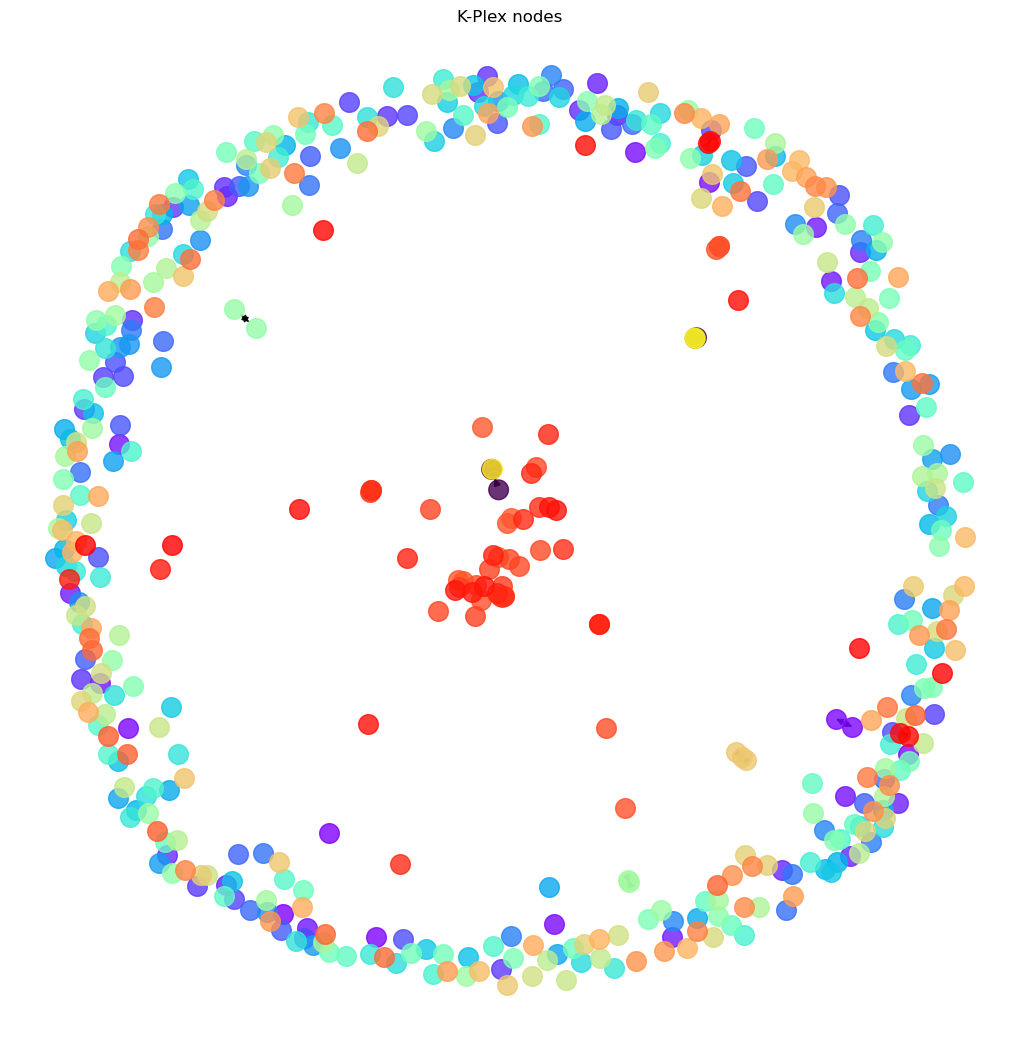

c:\Users\minda\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


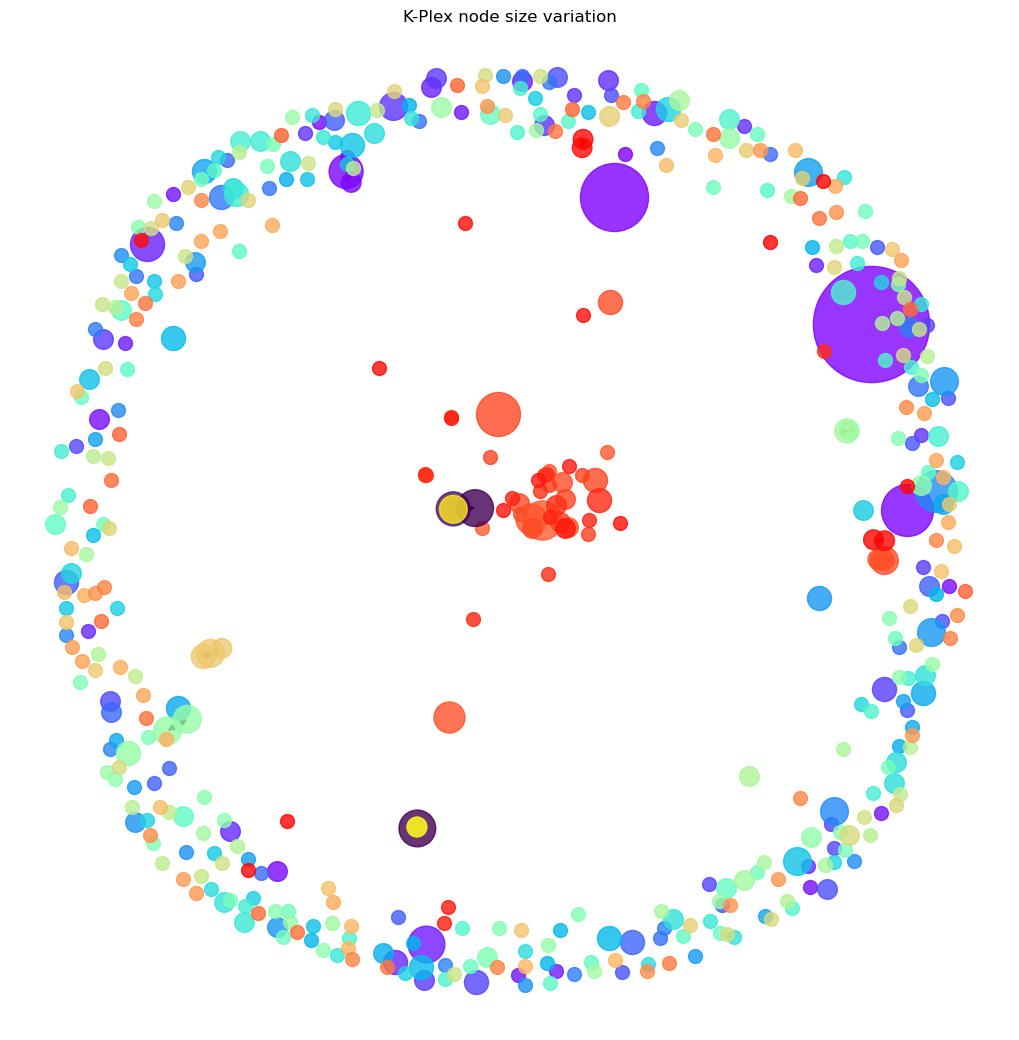

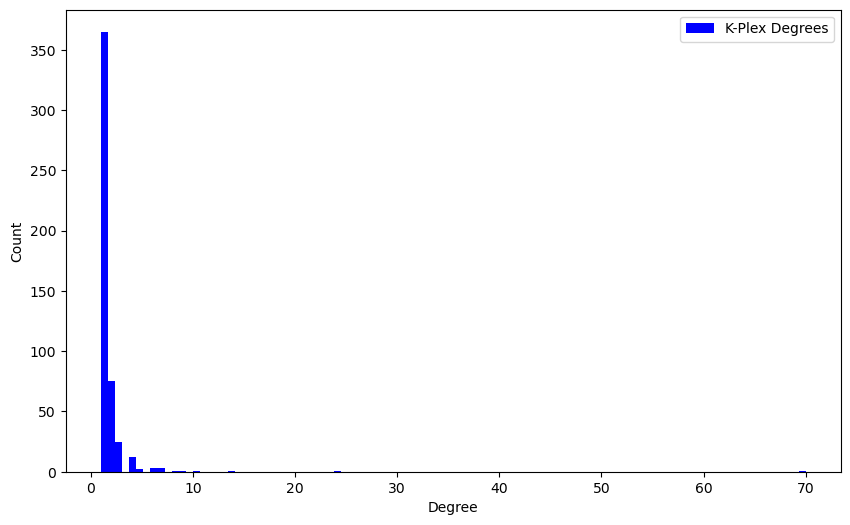

In [26]:
# Part C function call for part E, positive
name = "E_positive"
positive_k_plex_info = analyze_k_plexes(G_positive, name)

c:\Users\minda\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


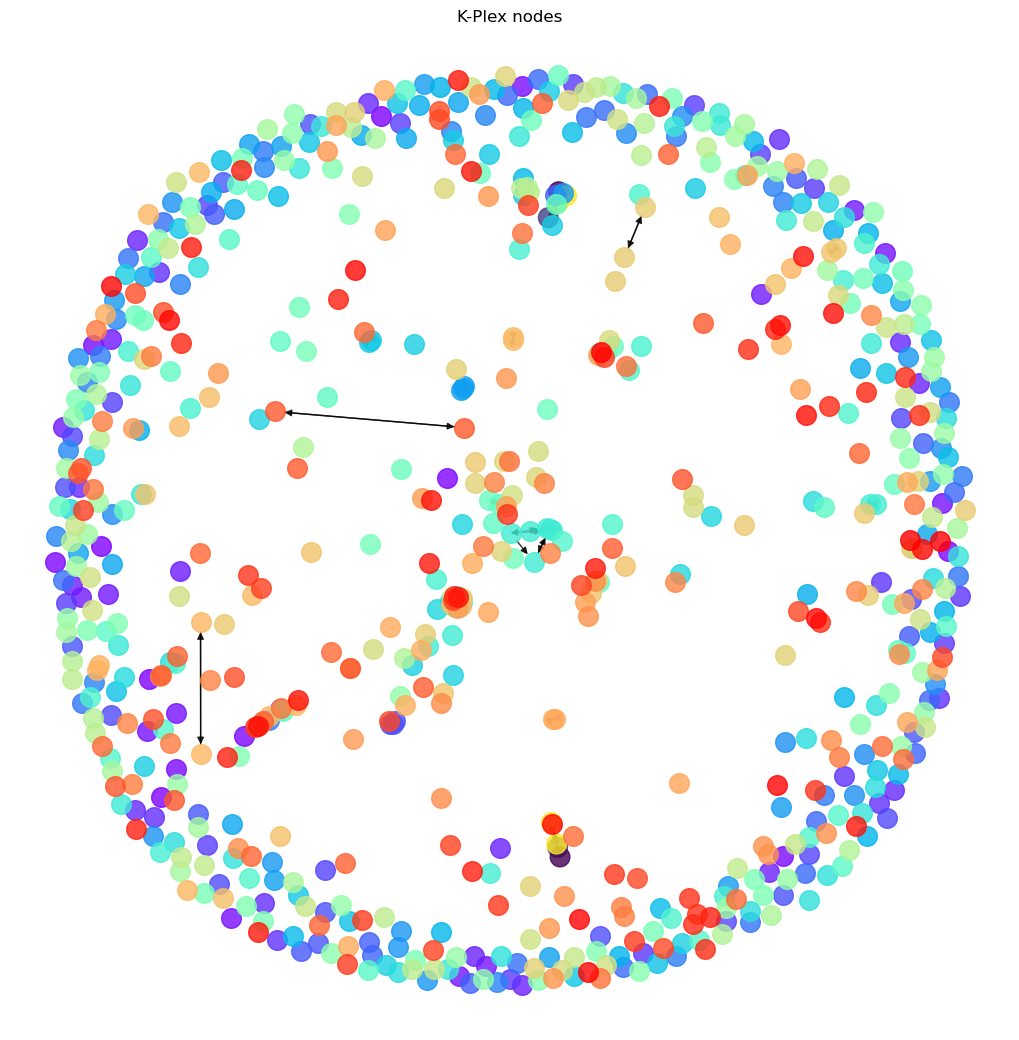

c:\Users\minda\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


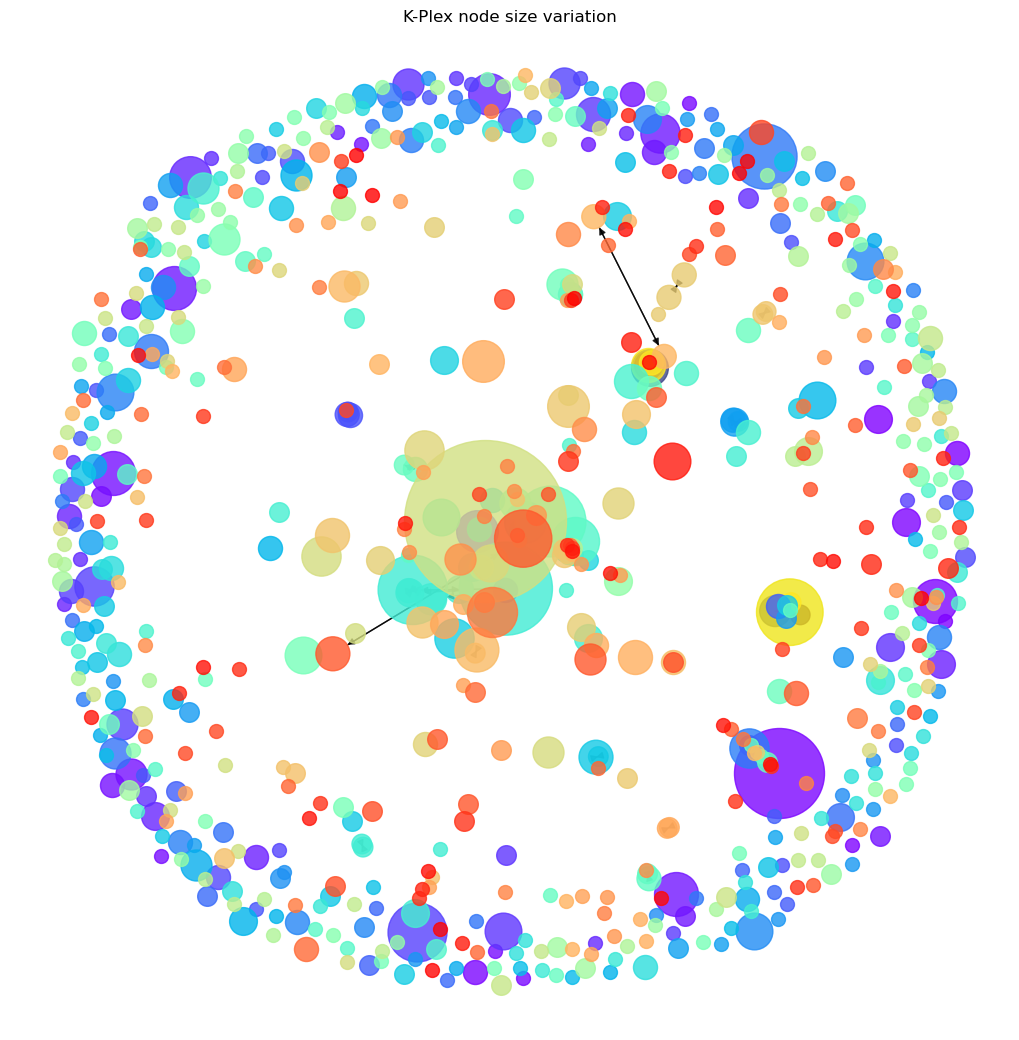

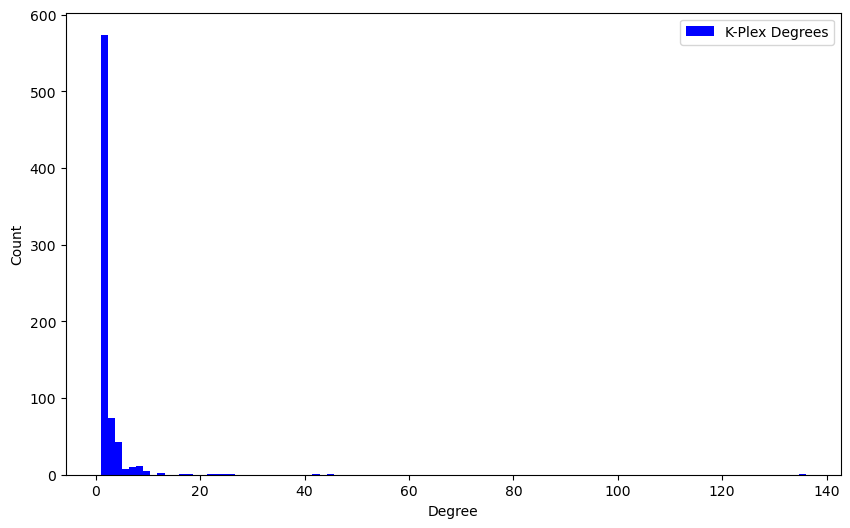

In [27]:
# Part C function call for part E, negative
name = "E_negative"
negative_k_plex_info = analyze_k_plexes(G_negative, name)

### Exploration of C for E

In [124]:
def plex(G, B, name):

    # Largest strongly connected component
    def largest_strongly_connected_component(graph):
        components = list(nx.strongly_connected_components(graph))
        largest_component = max(components, key=len)
        return graph.subgraph(largest_component)

    # Calculate k-value based on the minimum degree
    def calculate_k(subgraph):
        min_degree = min(dict(subgraph.degree()).values())
        k = max(1, min(len(subgraph) - min_degree, len(subgraph) // 2))
        return k

    # Find k-plexes in the directed graph
    def find_k_plex(graph, k):
        components = list(nx.strongly_connected_components(graph))
        k_plexes = []

        for component in components:
            subgraph = graph.subgraph(component)
            if all(degree >= (len(subgraph) - k) for _, degree in subgraph.degree()):
                k_plexes.append(subgraph)

        return k_plexes
    
    # Find k-plexes
    def find_k_plex(graph, min_k):
        components = list(nx.strongly_connected_components(graph))
        k_plexes = []

        for component in components:
            subgraph = graph.subgraph(component)
            k = max(min_k, calculate_k(subgraph))  # Use the larger of min_k and the calculated k
            if all(degree >= (len(subgraph) - k) for _, degree in subgraph.degree()):
                k_plexes.append(subgraph)

        return k_plexes
    
#--------------------------------------------
# NEW for Part E 

    # Histogram to compare amount of communities
    def compare_community_size_distribution(positive_communities, negative_communities):

        positive_sizes = [len(c) for c in positive_communities]
        negative_sizes = [len(c) for c in negative_communities]

        all_sizes = positive_sizes + negative_sizes
        min_size = min(all_sizes)
        max_size = max(all_sizes)

        # Create a consistent range of bins
        bins = np.linspace(min_size, max_size, num=12)
        plt.figure(figsize=(10, 6))
        plt.hist(positive_sizes, bins=bins, alpha=0.5, color = "blue", label='Positive Network')
        plt.hist(negative_sizes, bins=bins, alpha=0.5, color = "yellow", label='Negative Network')
        plt.xlabel('Community Size')
        plt.ylabel('Number of Communities')
        plt.yscale('log')
        plt.legend(loc='upper right')
        filename = "plots/E_" + name + "_k_plex_compared_histogram_log.pdf"
        plt.savefig(filename)
        plt.show()

    # Venn diagram to see Pos+Neg community overlap
    def visualize_node_overlap(positive_communities, negative_communities):
        positive_nodes = set().union(*positive_communities)
        negative_nodes = set().union(*negative_communities)

        venn2([positive_nodes, negative_nodes], set_labels = ('Positive Network', 'Negative Network'), set_colors = ("green", "red"))
        filename = "plots/E_" + name + "_k_plex_venn.pdf"
        plt.savefig(filename)
        plt.show()

    # Function to find and return the overlapping nodes to be used later
    def get_exclusive_communities(all_communities, overlapping_nodes):
        exclusive_communities = []
        for community in all_communities:
            # Create a new subgraph for each community excluding the overlapping nodes
            exclusive_nodes = set(community.nodes()) - overlapping_nodes
            if exclusive_nodes:  # Check if the community still has nodes after excluding
                exclusive_community = community.subgraph(exclusive_nodes).copy()
                exclusive_communities.append(exclusive_community)
        return exclusive_communities

    # Draw nodes of all three (pos, neg, overlap) for comparison of size and count
    def plot_overlap(graph, positive_nodes, negative_nodes, overlapping_nodes):
        pos = nx.spring_layout(graph)  # Layout
        plt.figure(figsize=(10, 10))

        # Vary node size based on degree
        degrees = dict(graph.degree())
        
        # Draw nodes for positive, negative and overlapping nodes
        nx.draw_networkx_nodes(graph, pos, nodelist=positive_nodes, node_color='green', alpha=0.8, 
                            node_size=[degrees[node] * 100 for node in positive_nodes])
        nx.draw_networkx_nodes(graph, pos, nodelist=negative_nodes, node_color='red', alpha=0.8, 
                            node_size=[degrees[node] * 100 for node in negative_nodes])
        nx.draw_networkx_nodes(graph, pos, nodelist=overlapping_nodes, node_color='blue', alpha=0.8, 
                            node_size=[degrees[node] * 100 for node in overlapping_nodes])
        
        filename = "plots/E_" + name + "_all_overlap_k_plex.pdf"
        plt.savefig(filename)
        #plt.title(f"K-Plex node size variation")
        plt.show()

    # Conducting analysis
    # Split for positive and negative network
    largest_component_G = largest_strongly_connected_component(G)
    largest_component_B = largest_strongly_connected_component(B)

    # Testing purposes, experimented with both k-values for both networks, unsatisfactory results
    k = min(calculate_k(largest_component_G), calculate_k(largest_component_B))
    #print(calculate_k(largest_component_G))
    #print(calculate_k(largest_component_B))

    # Find k-plexes for both networks
    k_plexes_G = find_k_plex(G, calculate_k(largest_component_G))
    k_plexes_B = find_k_plex(B, calculate_k(largest_component_B))

    # Draw histogram
    compare_community_size_distribution(k_plexes_B, k_plexes_G)
    
    # Draw venn diagram
    #visualize_node_overlap(k_plexes_B, k_plexes_G)

    # Get the overlapping nodes
    positive_nodes = set().union(*k_plexes_G)
    negative_nodes = set().union(*k_plexes_B)
    overlapping_nodes = positive_nodes & negative_nodes

    # Get exclusive communities for each network
    excl_k_plexes_G = get_exclusive_communities(k_plexes_G, overlapping_nodes)
    excl_k_plexes_B = get_exclusive_communities(k_plexes_B, overlapping_nodes)

    # New names for saving files
    name_G = name + "_removed_negative_"
    name_B = name + "_removed_positive_"
    
    # Recombining the datasets to have a single base variable for plotting
    G_composed = nx.compose(G, B)

    # Plot the three different overlaps
    #plot_overlap(G_composed, positive_nodes, negative_nodes, overlapping_nodes)
    
    return (k, k_plexes_G)

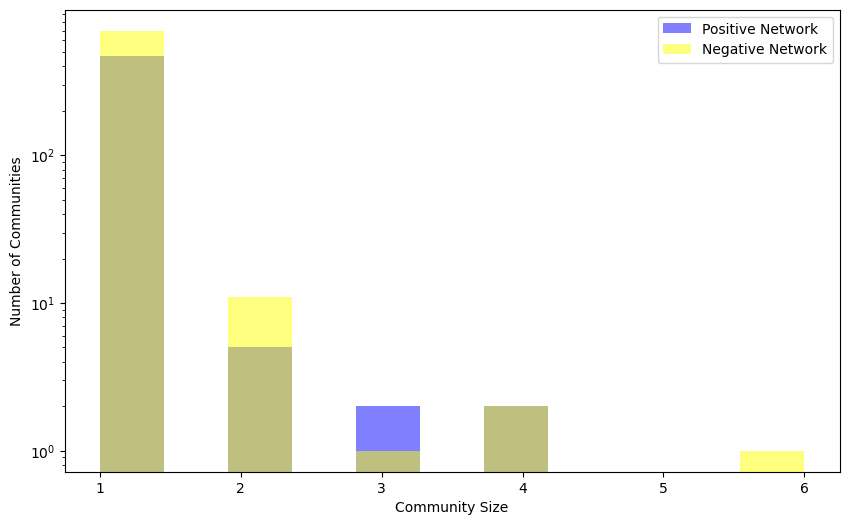

In [125]:
name = "Overlap"
comparison_plex = plex(G_negative, G_positive, name)